In [1]:
import random
import time
from functools import reduce
import numpy as np

In [2]:
def calc_makespan(solution, proccessing_time, number_of_jobs, number_of_machines):
    # list for the time passed until the finishing of the job
    cost = [0] * number_of_jobs
    # for each machine, total time passed will be updated
    for machine_no in range(0, number_of_machines):
        for slot in range(number_of_jobs):
            # time passed so far until the task starts to process
            cost_so_far = cost[slot]
            if slot > 0:
                cost_so_far = max(cost[slot - 1], cost[slot])
            cost[slot] = cost_so_far + proccessing_time[solution[slot]][machine_no]
    return cost[number_of_jobs - 1]

In [3]:
def initialize_population(population_size, number_of_jobs):
    population = []
    i = 0
    while i < population_size:
        individual = list(np.random.permutation(number_of_jobs))
        if individual not in population:
            population.append(individual)
            i += 1

    return population

In [4]:
def crossover(parents):
    parent1 = parents[0]
    parent2 = parents[1]
    length_of_parent = len(parent1)
    first_point = int(length_of_parent / 2 - length_of_parent / 4)
    second_point = int(length_of_parent - first_point)
    intersect = parent1[first_point:second_point]

    child = []
    index = 0
    for pos2 in range(len(parent2)):
        if first_point <= index < second_point:
            child.extend(intersect)
            index = second_point
        if parent2[pos2] not in intersect:
                child.append(parent2[pos2])
                index += 1

    return child

In [5]:
def mutation(solution):
    # copy the solution
    mutated_solution = list(solution)
    solution_length = len(solution)
    # pick 2 positions to swap randomly
    swap_positions = list(np.random.permutation(np.arange(solution_length))[:2])
    first_job = solution[swap_positions[0]]
    second_job = solution[swap_positions[1]]
    mutated_solution[swap_positions[0]] = second_job
    mutated_solution[swap_positions[1]] = first_job
    return mutated_solution

In [19]:
def select_parent(population, processing_time, number_of_jobs, number_of_machines, method, n_parents):
    parent_pairs = []
    parent_pair_count = n_parents
    if(method == 'Tournament'):
    # randomly choose how many parent pairs will be selected
        for k in range(parent_pair_count):
            parent1 = binary_tournament(number_of_jobs, number_of_machines, population, processing_time)
            parent2 = binary_tournament(number_of_jobs, number_of_machines, population, processing_time)
            if parent1 != parent2 and (parent1, parent2) not in parent_pairs:
                parent_pairs.append((parent1, parent2))
    elif(method == 'Elite'):
        selected_parents = elite_selection(population, processing_time, number_of_jobs, number_of_machines, n_parents)
        for k in range(parent_pair_count - 1):
            parent_pairs.append((selected_parents[k], selected_parents[k+1]))  
    elif(method == 'Roulette'):
        for k in range(parent_pair_count):
            parent1 = roulette_selection(population, processing_time, number_of_jobs, number_of_machines)
            parent2 = roulette_selection(population, processing_time, number_of_jobs, number_of_machines)
            if((parent1 != parent2) and (parent1, parent2) not in parent_pairs):
                parent_pairs.append((parent1, parent2)) 
    elif(method == 'Random'):
        selected_parents = random_selection(population)
        for k in range(parent_pair_count - 1):
            parent1 = random_selection(population)
            parent2 = random_selection(population)
            if((parent1 != parent2) and (parent1, parent2) not in parent_pairs):
                parent_pairs.append((parent1, parent2)) 
    else:
        raise 'Unknown Selection Method'                                        
    return parent_pairs

In [7]:
def elite_selection(population, processing_time, number_of_jobs, number_of_machines, n_parents):
    population_sorted = sorted(population, key=lambda x: calc_makespan(x, processing_time, number_of_jobs, number_of_machines), reverse=True)
    return population_sorted[:n_parents]

In [8]:
def roulette_selection(population, processing_time, number_of_jobs, number_of_machines):
    population_sorted = sorted(population, key=lambda x: calc_makespan(x, processing_time, number_of_jobs, number_of_machines))
    total_spans = sum([calc_makespan(x, processing_time, number_of_jobs, number_of_machines) for x in population])
    spans = [calc_makespan(x, processing_time, number_of_jobs, number_of_machines) / total_spans for x in population_sorted]
    cumul_sums = np.cumsum(np.array(spans))
    r =  np.random.rand()
    index = np.argwhere(r <= cumul_sums)
    return population_sorted[index[0][0]]

In [9]:
def random_selection(population):
    return population[np.random.randint(len(population))]

In [10]:
def binary_tournament(number_of_jobs, number_of_machines, population, processing_time):
    parent = []
    candidates = random.sample(population, 2)
    makespan1 = calc_makespan(candidates[0], processing_time, number_of_jobs, number_of_machines)
    makespan2 = calc_makespan(candidates[1], processing_time, number_of_jobs, number_of_machines)
    if makespan1 < makespan2:
        parent = candidates[0]
    else:
        parent = candidates[1]
    return parent

In [12]:
def update_population(population, children, processing_time, no_of_jobs, no_of_machines):
    costed_population = []
    for individual in population:
        ind_makespan = (calc_makespan(individual, processing_time, no_of_jobs, no_of_machines), individual)
        costed_population.append(ind_makespan)
    costed_population.sort(key=lambda x: x[0], reverse=True)
    costed_children = []
    for individual in children:
        ind_makespan = (calc_makespan(individual, processing_time, no_of_jobs, no_of_machines), individual)
        costed_children.append(ind_makespan)
    costed_children.sort(key=lambda x: x[0])
    for child in costed_children:
        if child not in population:
            population.append(individual)
            population.remove(costed_population[0][1])
            break

In [26]:
# main function 
# parameters 
# n_iter -> number of iterations
# n_pop -> population size
# p_c -> crossover proba
# p_m -> mutation proba
# instance : ID of the taillard instance (0-5)
# method : parent selection method ('Tournament', 'Roulette', 'Elite', 'Random')
# n_parents : number of parents to select for the selection phase
# returns : gap , execTime , sequence and Cmax

def run_ga(n_iter, n_pop, p_c, p_m, instance, method, n_parents):
    # Start execution
    optimal = [1278, 1359, 5493, 6286, 11294, 26189]
    opt = instance
    filename = "data" + str(opt) + ".txt"
    file = open(filename, 'r')
    line = file.readline().split()

    # number of jobs and machines
    no_of_jobs, no_of_machines = int(line[0]), int(line[1])

    # i-th job's processing time at j-th machine 
    processing_time = []

    for i in range(no_of_jobs):
        temp = []
        line = file.readline().split()
        for j in range(no_of_machines):
            temp.append(int(line[2 * j + 1]))
        processing_time.append(temp)
    #print(processing_time)

    # generate an initial population proportional to no_of_jobs
    number_of_population = n_pop #no_of_jobs**2
    no_of_iterations = n_iter
    p_crossover = p_c
    p_mutation = p_m

    # Initialize population
    population = initialize_population(number_of_population, no_of_jobs)

    # Start time for CPU calculation
    start_time = time.process_time()

    for evaluation in range(no_of_iterations):
        # Select parents
        parent_list = select_parent(population, processing_time, no_of_jobs, no_of_machines, method, n_parents)
        childs = []

        # Apply crossover to generate children
        for parents in parent_list:
            r = np.random.rand()
            if r < p_crossover:
                childs.append(crossover(parents))
            else:
                if r < 0.5:
                    childs.append(parents[0])
                else:
                    childs.append(parents[1])

        # Apply mutation operation to change the order of the n-jobs
        mutated_childs = []
        for child in childs:
            r = np.random.rand()
            if r < p_mutation:
                mutated_child = mutation(child)
                mutated_childs.append(mutated_child)

        childs.extend(mutated_childs)
        if len(childs) > 0:
            update_population(population, childs, processing_time, no_of_jobs, no_of_machines)

    # End time for CPU calculation        
    end_time = time.process_time()

    costed_population = []
    for individual in population:
        ind_makespan = (calc_makespan(individual, processing_time, no_of_jobs, no_of_machines), individual)
        costed_population.append(ind_makespan)
    costed_population.sort(key=lambda x: x[0])

    avgObjective = sum(t[0] for t in costed_population) / len(costed_population)
    bestObjective = costed_population[0][0]
    gap = (100 * (bestObjective - optimal[opt]) / optimal[opt])
    exec_time = end_time - start_time

    data = {'Cmax': bestObjective, 'gap': gap, 'execTime': exec_time}

    return data

In [27]:
results = []
for i in range(20):
    data = run_ga(100, 100 + 50*i, 1.0, 1.0, 5, 'Tournament', 10)
    results.append(data)

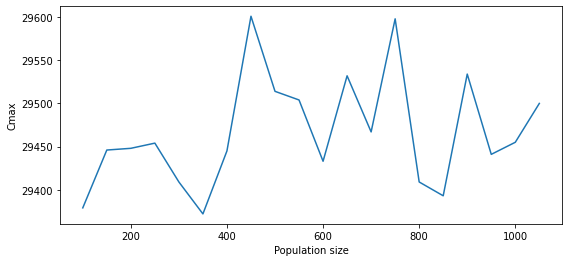

In [50]:
import matplotlib.pyplot as plt
x = [100 + 50*i for i in range(20)]
y = [t['Cmax'] for t in results[0:20]]
plt.figure(figsize=(9,4))
plt.xlabel('Population size')
plt.ylabel('Cmax')
plt.plot(x, y)
plt.show()


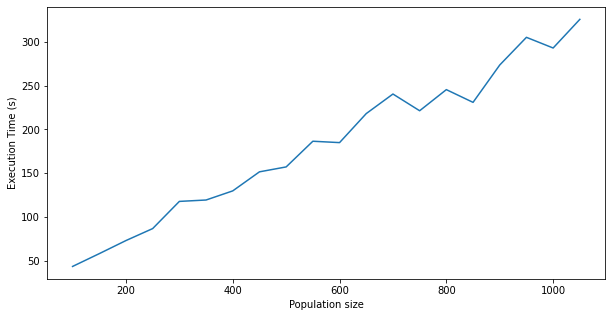

In [31]:
y2 = [t['execTime'] for t in results]
plt.figure(figsize=(10,5))
plt.xlabel('Population size')
plt.ylabel('Execution Time (s)')
plt.plot(x, y2)
plt.show()

ValueError: x and y must have same first dimension, but have shapes (10,) and (30,)

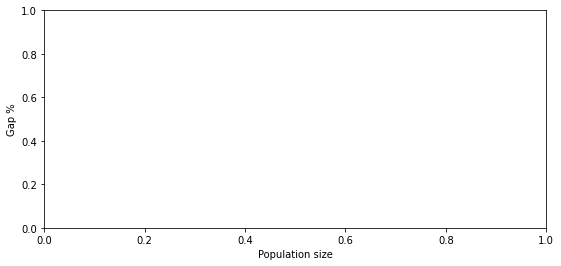

In [48]:
y3 = [t['gap'] for t in results[0:20]]
plt.figure(figsize=(9,4))
plt.xlabel('Population size')
plt.ylabel('Gap %')
plt.plot(x, y3)
plt.show()

In [34]:
best_solution = sorted(results, key=lambda x: x['gap'])[0]

In [35]:
best_solution

{'Cmax': 29372, 'gap': 12.153957768528771, 'execTime': 119.453125}

### Best Population size = 350

In [36]:
results2 = []
for i in range(1, 11):
    data = run_ga(100*i, 350, 1.0, 1.0, 5, 'Tournament', 10)
    results.append(data)

In [39]:
results2 = results[20:]
len(results2)

10

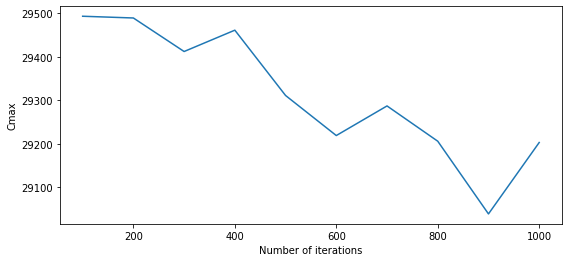

In [47]:
x = [100*i for i in range(1,11)]
y4 = [t['Cmax'] for t in results2]
plt.figure(figsize=(9,4))
plt.xlabel('Number of iterations')
plt.ylabel('Cmax')
plt.plot(x, y4)
plt.show()

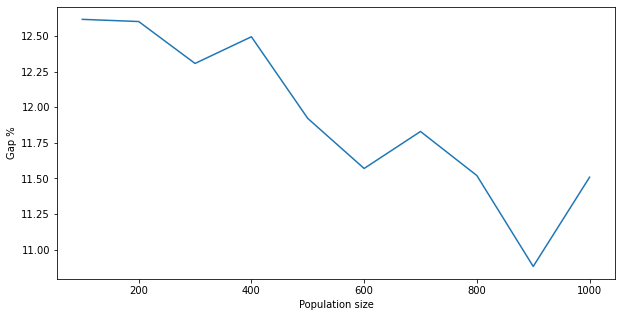

In [42]:
x = [100*i for i in range(1,11)]
y5 = [t['gap'] for t in results2]
plt.figure(figsize=(10,5))
plt.xlabel('Population size')
plt.ylabel('Gap %')
plt.plot(x, y5)
plt.show()

### Best number of iterations = 900 

In [51]:
results3 = []
methods = ['Tournament', 'Roulette', 'Elite', 'Random']
for method in methods:
    data = run_ga(100, 350, 1.0, 1.0, 5, method, 10)
    results3.append(data)

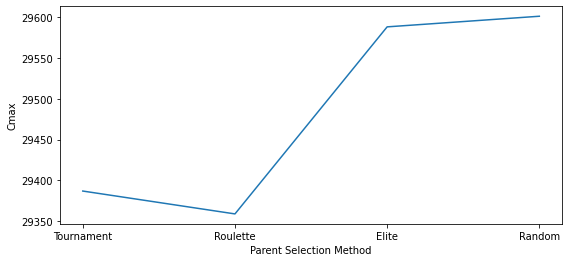

In [52]:
y5 = [r['Cmax'] for r in results3]
plt.figure(figsize=(9, 4))
plt.plot(methods, y5)
plt.xlabel('Parent Selection Method')
plt.ylabel('Cmax')
plt.show()

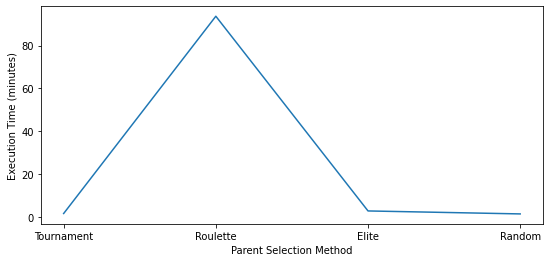

In [55]:
y6 = [r['execTime'] / 60 for r in results3]
plt.figure(figsize=(9, 4))
plt.plot(methods, y6)
plt.xlabel('Parent Selection Method')
plt.ylabel('Execution Time (minutes)')
plt.show()

In [58]:
results4 = []
for i in range(1, 11):
    data = run_ga(10, 350, 1.0, 1.0, 5, 'Tournament', i*10)
    results4.append(data)

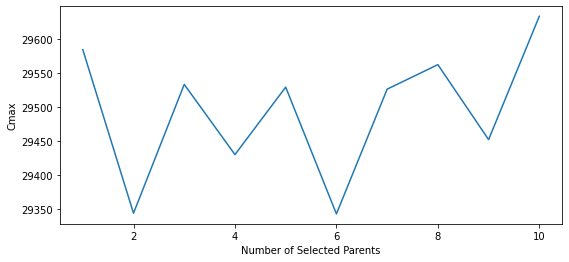

In [60]:
y7 = [r['Cmax'] for r in results4]
plt.figure(figsize=(9, 4))
plt.plot(list(range(1,11)), y7)
plt.xlabel('Number of Selected Parents')
plt.ylabel('Cmax')
plt.show()

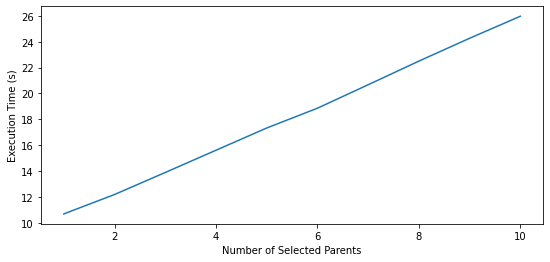

In [61]:
y8 = [r['execTime'] for r in results4]
plt.figure(figsize=(9, 4))
plt.plot(list(range(1,11)), y8)
plt.xlabel('Number of Selected Parents')
plt.ylabel('Execution Time (s)')
plt.show()